# Fine-Tuning with Native Pytorch

In [1]:
!pip install transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00


# One-step forward

In [2]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [3]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [4]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [5]:
# one step forward
import torch
texts= ["this is a good example","this is a bad example","this is indispensable", "it is"]
labels= [1,0,1,1]
labels = torch.tensor(labels).unsqueeze(0)

In [6]:
encoding = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
input_ids = encoding['input_ids']
attention_mask = encoding['attention_mask']

In [7]:
input_ids

tensor([[  101,  2023,  2003,  1037,  2204,  2742,   102,     0],
        [  101,  2023,  2003,  1037,  2919,  2742,   102,     0],
        [  101,  2023,  2003, 27427,  2483, 11837, 19150,   102],
        [  101,  2009,  2003,   102,     0,     0,     0,     0]])

In [8]:
tokenizer.convert_ids_to_tokens(input_ids[2])

['[CLS]', 'this', 'is', 'ind', '##is', '##pen', '##sable', '[SEP]']

In [9]:
attention_mask

tensor([[1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0, 0]])

In [10]:
labels

tensor([[1, 0, 1, 1]])

In [11]:
outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
loss = outputs.loss
loss.backward()
optimizer.step()

In [12]:
outputs

SequenceClassifierOutput(loss=tensor(0.6863, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.1048,  0.0985],
        [-0.0170,  0.1965],
        [ 0.0581,  0.1478],
        [-0.0263,  0.1827]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [13]:
outputs.loss

tensor(0.6863, grad_fn=<NllLossBackward0>)

In [14]:
outputs.logits

tensor([[ 0.1048,  0.0985],
        [-0.0170,  0.1965],
        [ 0.0581,  0.1478],
        [-0.0263,  0.1827]], grad_fn=<AddmmBackward0>)

In [15]:
#Manually calculate loss
from torch.nn import functional
labels = torch.tensor([1,0,1,1])
outputs = model(input_ids, attention_mask=attention_mask)
loss = functional.cross_entropy(outputs.logits, labels)
loss.backward()
optimizer.step()
loss

tensor(0.5303, grad_fn=<NllLossBackward0>)

In [16]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[-0.6501,  0.6521],
        [-0.6444,  0.3894],
        [-0.5712,  0.5158],
        [-0.6453,  0.6048]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

## Training the model from entire dataset with Native PyTorch

In [17]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [18]:
from transformers import DistilBertForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
from transformers import BertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
import datasets
from datasets import load_dataset
sst2= load_dataset("glue","sst2")
from datasets import load_metric
metric = load_metric("glue", "sst2")

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

<ipython-input-19-6ba68a33fae5>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("glue", "sst2")


In [20]:
texts=sst2['train']['sentence']
labels=sst2['train']['label']
val_texts=sst2['validation']['sentence']
val_labels=sst2['validation']['label']

In [21]:
len(texts)

67349

In [22]:
# I will take small portion
K=10000
train_dataset= MyDataset(tokenizer(texts[:K], truncation=True, padding=True), labels[:K])
val_dataset=  MyDataset(tokenizer(val_texts, truncation=True, padding=True), val_labels)

In [23]:
from tqdm import tqdm

In [24]:
from torch.utils.data import DataLoader
from transformers import  AdamW

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader =  DataLoader(val_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=1e-5)

for epoch in range(3):
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()
    model.eval()
    for batch in tqdm(val_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        predictions=outputs.logits.argmax(dim=-1)
        metric.add_batch(
                predictions=predictions,
                references=batch["labels"],
            )
    eval_metric = metric.compute()
    print(f"epoch {epoch}: {eval_metric}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 55/55 [00:01<00:00, 37.01it/s]


epoch 0: {'accuracy': 0.8887614678899083}


100%|██████████| 55/55 [00:01<00:00, 37.94it/s]


epoch 1: {'accuracy': 0.8876146788990825}


100%|██████████| 55/55 [00:01<00:00, 38.14it/s]


epoch 2: {'accuracy': 0.8990825688073395}


In [25]:
import numpy as np

In [26]:
np.log(1)


0.0

In [27]:
ys   =[0,0,1,1]
preds=[0,1,0,1]

In [28]:
# yi * log(pred_i) + (1-yi) * log(1- pred_i))
# 0,0 -> 1 * log(1) : 0

In [29]:
def my_log(x):
  if x<=0:
    return -10
  else:
    return np.log(x)

def loss(yi, pi):
  return -yi * my_log(pi) - (1-yi) * my_log(1- pi)

In [30]:
loss(0,0),loss(0,1), loss(1,0), loss(1,1)

(0.0, 10.0, 10.0, -0.0)

In [32]:
import pandas as pd


losses=pd.Series([loss(1,e/100) for e in range(100)])

<Axes: >

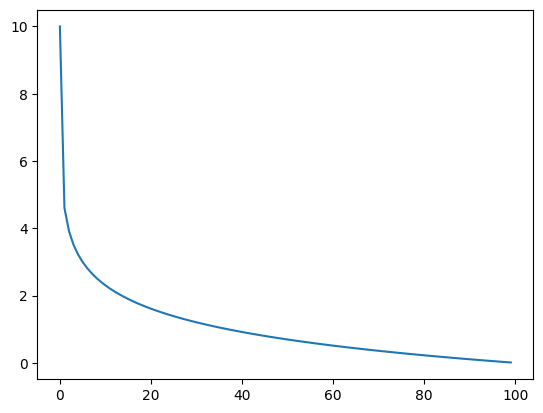

In [33]:
losses.plot()

In [35]:
import tensorflow as tf


In [36]:
# Example 1: (batch_size = 1, number of samples = 4)
y_true = [0, 1, 0, 0]
y_pred = [-18.6, 0.51, 2.94, -12.8]
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bce(y_true, y_pred).numpy()

0.865458

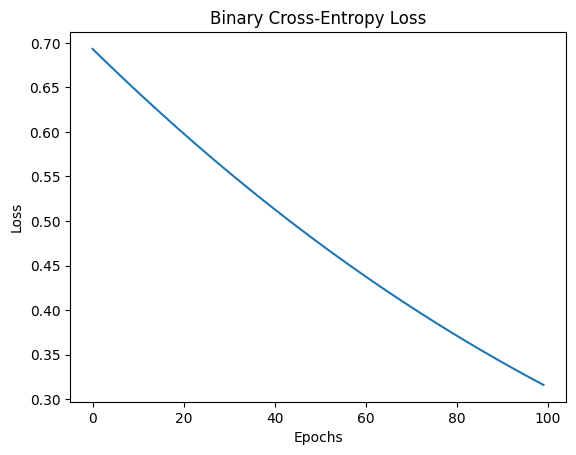

In [37]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Sample function to compute loss (you can replace this with your actual loss function)
def compute_loss(target, prediction):
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return bce([target], [prediction]).numpy()

# Compute losses
losses = [compute_loss(1, e/100) for e in range(100)]

# Plotting
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Cross-Entropy Loss')
plt.show()
